In [57]:
import tinkoff.invest as tapi
import os
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from decimal import Decimal
from datetime import datetime, timedelta
from tqdm.auto import tqdm, trange

token = os.environ["TBANK_SANDBOX"]
print(len(token))

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


88


In [14]:
def add_money(
    client: tapi.services.Services,
    account_id: tapi.typedefs.AccountId,
    money: str | int | Decimal,
) -> None:
    total_amount = Decimal(money)
    step_amount = tapi.utils.decimal_to_money(Decimal("100_000"), currency="rub")
    cur_balance = Decimal("0")

    response = None
    while cur_balance < total_amount:
        response = client.sandbox.sandbox_pay_in(
            account_id=account_id,
            amount=step_amount
        )
        cur_balance = tapi.utils.money_to_decimal(response.balance)

    if response:
        logger.info(f"Текущий счет:\n{response}")

def init_sandbox(
    client: tapi.services.Services, 
    money: str | int | Decimal | None = None,
) -> tapi.Account:
    sandbox_accounts = client.users.get_accounts()

    logger.info(f"Количество существующих sandbox аккаунтов для удаления: {len(sandbox_accounts.accounts)}")
    for acc in sandbox_accounts.accounts:
        client.sandbox.close_sandbox_account(account_id=acc.id)

    account = client.sandbox.open_sandbox_account()
    account_id = account.account_id
    
    logger.info(f"Новый sandbox аккаунт: {account_id}")

    if money:
        add_money(client, account_id, money)
    
    return account




In [34]:
with tapi.Client(token, target=tapi.constants.INVEST_GRPC_API_SANDBOX) as client:
    
    # ================================================
    # === Очищаем старые аккаунты, открываем новый === 
    # ================================================
    account_id = init_sandbox(client)

    shares = client.instruments.shares()

    candles = []
    cur_time = datetime.strptime("2025-10-10", "%Y-%m-%d")
    period = timedelta(minutes=200)

    periods = (datetime.now() - cur_time) // period
    
    for _ in trange(periods, desc="Loading candles"):
        candles_response = client.market_data.get_candles(
            figi="BBG004730N88",
            from_=cur_time,
            to=cur_time + period,
            interval=tapi.CandleInterval.CANDLE_INTERVAL_5_SEC
        )
        candles.extend(candles_response.candles)
        cur_time += period


INFO:tinkoff.invest.logging:22a18d52b339a73e0d63e569ba9394e1 GetAccounts
INFO:__main__:Количество существующих sandbox аккаунтов для удаления: 1
INFO:tinkoff.invest.logging:b0aef1e7968ef6a2ce5d10f7bb669d8a CloseSandboxAccount
INFO:tinkoff.invest.logging:ae55f4b5f1cf432b66f13c0a641a9567 OpenSandboxAccount
INFO:__main__:Новый sandbox аккаунт: d8b90291-63bf-42ea-8023-a37f37addd20
INFO:tinkoff.invest.logging:25fbec55f67c6619cae417c130ad8a0e Shares


Loading candles:   0%|          | 0/191 [00:00<?, ?it/s]

INFO:tinkoff.invest.logging:da971d67905f441ce954225849e3bbf6 GetCandles
INFO:tinkoff.invest.logging:f8d9c800808476aad1aa8b1e3f1f1a2d GetCandles
INFO:tinkoff.invest.logging:c1d7d3b514a23cf7f64d7feed432bd8f GetCandles
INFO:tinkoff.invest.logging:dcc6178b67c31c9cabfad35570bd8861 GetCandles
INFO:tinkoff.invest.logging:fa1fda0c570bc29710ae1c32abe2b783 GetCandles
INFO:tinkoff.invest.logging:4362394461690fbcfa218a782872313f GetCandles
INFO:tinkoff.invest.logging:d2685718c3c0e322b0d344380e2a76f1 GetCandles
INFO:tinkoff.invest.logging:e1be325e44f0c6307f2c1e133bf35e8e GetCandles
INFO:tinkoff.invest.logging:1b40d282384279137b5bc3bef17857ec GetCandles
INFO:tinkoff.invest.logging:9b027c474ff07521087fd78876b0d382 GetCandles
INFO:tinkoff.invest.logging:a3d45d86cc51838542cb028ace0ff790 GetCandles
INFO:tinkoff.invest.logging:900d10577b1aace8bf38e3713870e165 GetCandles
INFO:tinkoff.invest.logging:c3feb1d8d569d209907a5301103c2e36 GetCandles
INFO:tinkoff.invest.logging:9ff45540ba684b5f21860e70d97e637f Get

In [31]:
(datetime.now() - datetime.strptime("2025-10-10", "%Y-%m-%d")) // timedelta(minutes=200)

191

In [25]:
instruments = shares.instruments
print(len(instruments))
print(instruments[0].ticker)
sber: tapi.Share = next(filter(lambda s: s.ticker == "SBER", instruments))
sber.figi

1930
SLM


'BBG004730N88'

In [35]:
print(len(candles))

257194


In [36]:
print(200 * 60 / 5)

2400.0


In [40]:
print(candles[0])

HistoricCandle(open=Quotation(units=289, nano=900000000), high=Quotation(units=289, nano=900000000), low=Quotation(units=289, nano=900000000), close=Quotation(units=289, nano=900000000), volume=2150, time=datetime.datetime(2025, 10, 10, 3, 59, 45, tzinfo=datetime.timezone.utc), is_complete=True, candle_source=<CandleSource.CANDLE_SOURCE_EXCHANGE: 1>)


In [53]:
sber_df = pd.DataFrame([
{
    "open_units": candles[i].open.units,
    "open_nano": candles[i].open.nano,
    "high_units": candles[i].high.units,
    "high_nano": candles[i].high.nano,
    "low_units": candles[i].low.units,
    "low_nano": candles[i].low.nano,
    "close_units": candles[i].close.units,
    "close_nano": candles[i].close.nano,
    "volume": candles[i].volume,
    "time": candles[i].time,
    "is_complete": candles[i].is_complete,
    "candle_source": candles[i].candle_source,
} for i in trange(len(candles))])

  0%|          | 0/257194 [00:00<?, ?it/s]

In [55]:
sber_df.head()

,open_units,open_nano,high_units,high_nano,low_units,low_nano,close_units,close_nano,volume,time,is_complete,candle_source
0,289,900000000,289,900000000,289,900000000,289,900000000,2150,2025-10-10 03:59:45+00:00,True,1
1,289,800000000,289,880000000,289,380000000,289,790000000,7028,2025-10-10 04:00:00+00:00,True,1
2,289,380000000,289,900000000,289,380000000,289,900000000,10030,2025-10-10 04:00:05+00:00,True,1
3,289,490000000,289,900000000,289,490000000,289,900000000,2396,2025-10-10 04:00:10+00:00,True,1
4,289,900000000,289,900000000,289,390000000,289,390000000,5850,2025-10-10 04:00:15+00:00,True,1


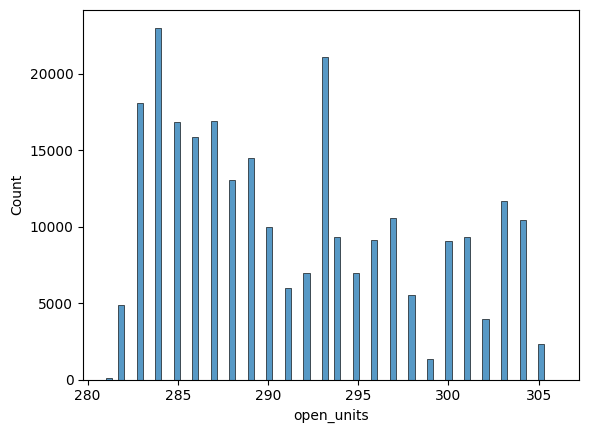

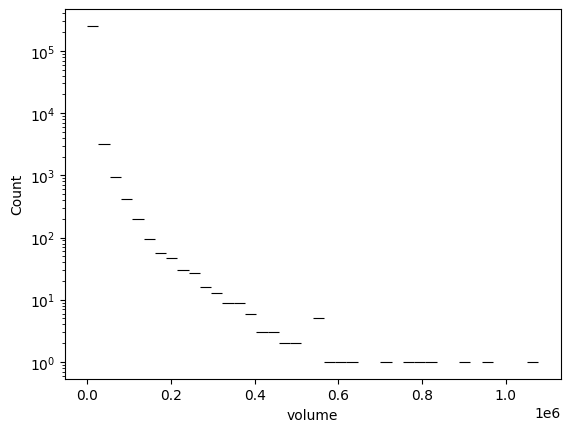

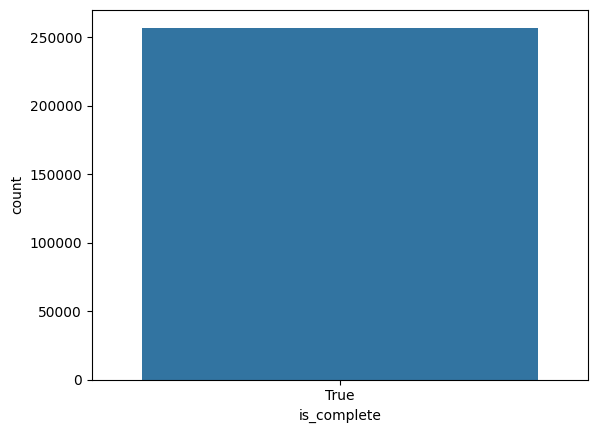

Count of falses in is_complete: 0


In [74]:
sns.histplot(sber_df, x="open_units")
plt.show()

sns.histplot(sber_df, x="volume", log_scale=(False, True), bins=40)
plt.show()

sns.barplot(sber_df["is_complete"].value_counts())
plt.show()

print(f"Count of falses in is_complete: {(sber_df["is_complete"] == False).sum()}")

In [75]:
from pathlib import Path

sber_df.to_csv(Path("datasets/sber.csv"))

In [ ]:
with tapi.Client(token, target=tapi.constants.INVEST_GRPC_API_SANDBOX) as client:
    client.market_data_stream.market_data_stream(

An error occurred: SubscribeLastPriceRequest
